In [1]:
%matplotlib inline
from __future__ import print_function, division
import os
import numpy as np
import pandas as pd
import flopy
from flopy.utils import HeadFile, CellBudgetFile
import matplotlib.pyplot as plt
from faspy.plot import ModelBaseMap
import sys
sys.path.append('..')
from FASModel import *

# load the model
pkglist = ['dis', 'bas6']
ml = flopy.modflow.Modflow.load('fas.nam', model_ws=os.path.join('..', '..'), load_only=pkglist, check=False)
print(os.path.abspath(ml.model_ws))
# print(ml.get_package_list())
print('perlen', ml.dis.perlen.array, 'day(s)')
print('nstp', ml.dis.nstp.array)
print('time-step length', ml.dis.perlen.array/ml.dis.nstp.array, 'day(s)')

E:\modflow\FAS.ss.predev.swi.testing
perlen [ 3650.] day(s)
nstp [1825]
time-step length [ 2.] day(s)


###Changes in Head
After the first time step, heads change rapidly in some areas, particularly near Mobile, AL where the system slopes steeply down under the Gulf. Starting heads are taken from a feeder model which simulates only the freshwater part of the system.

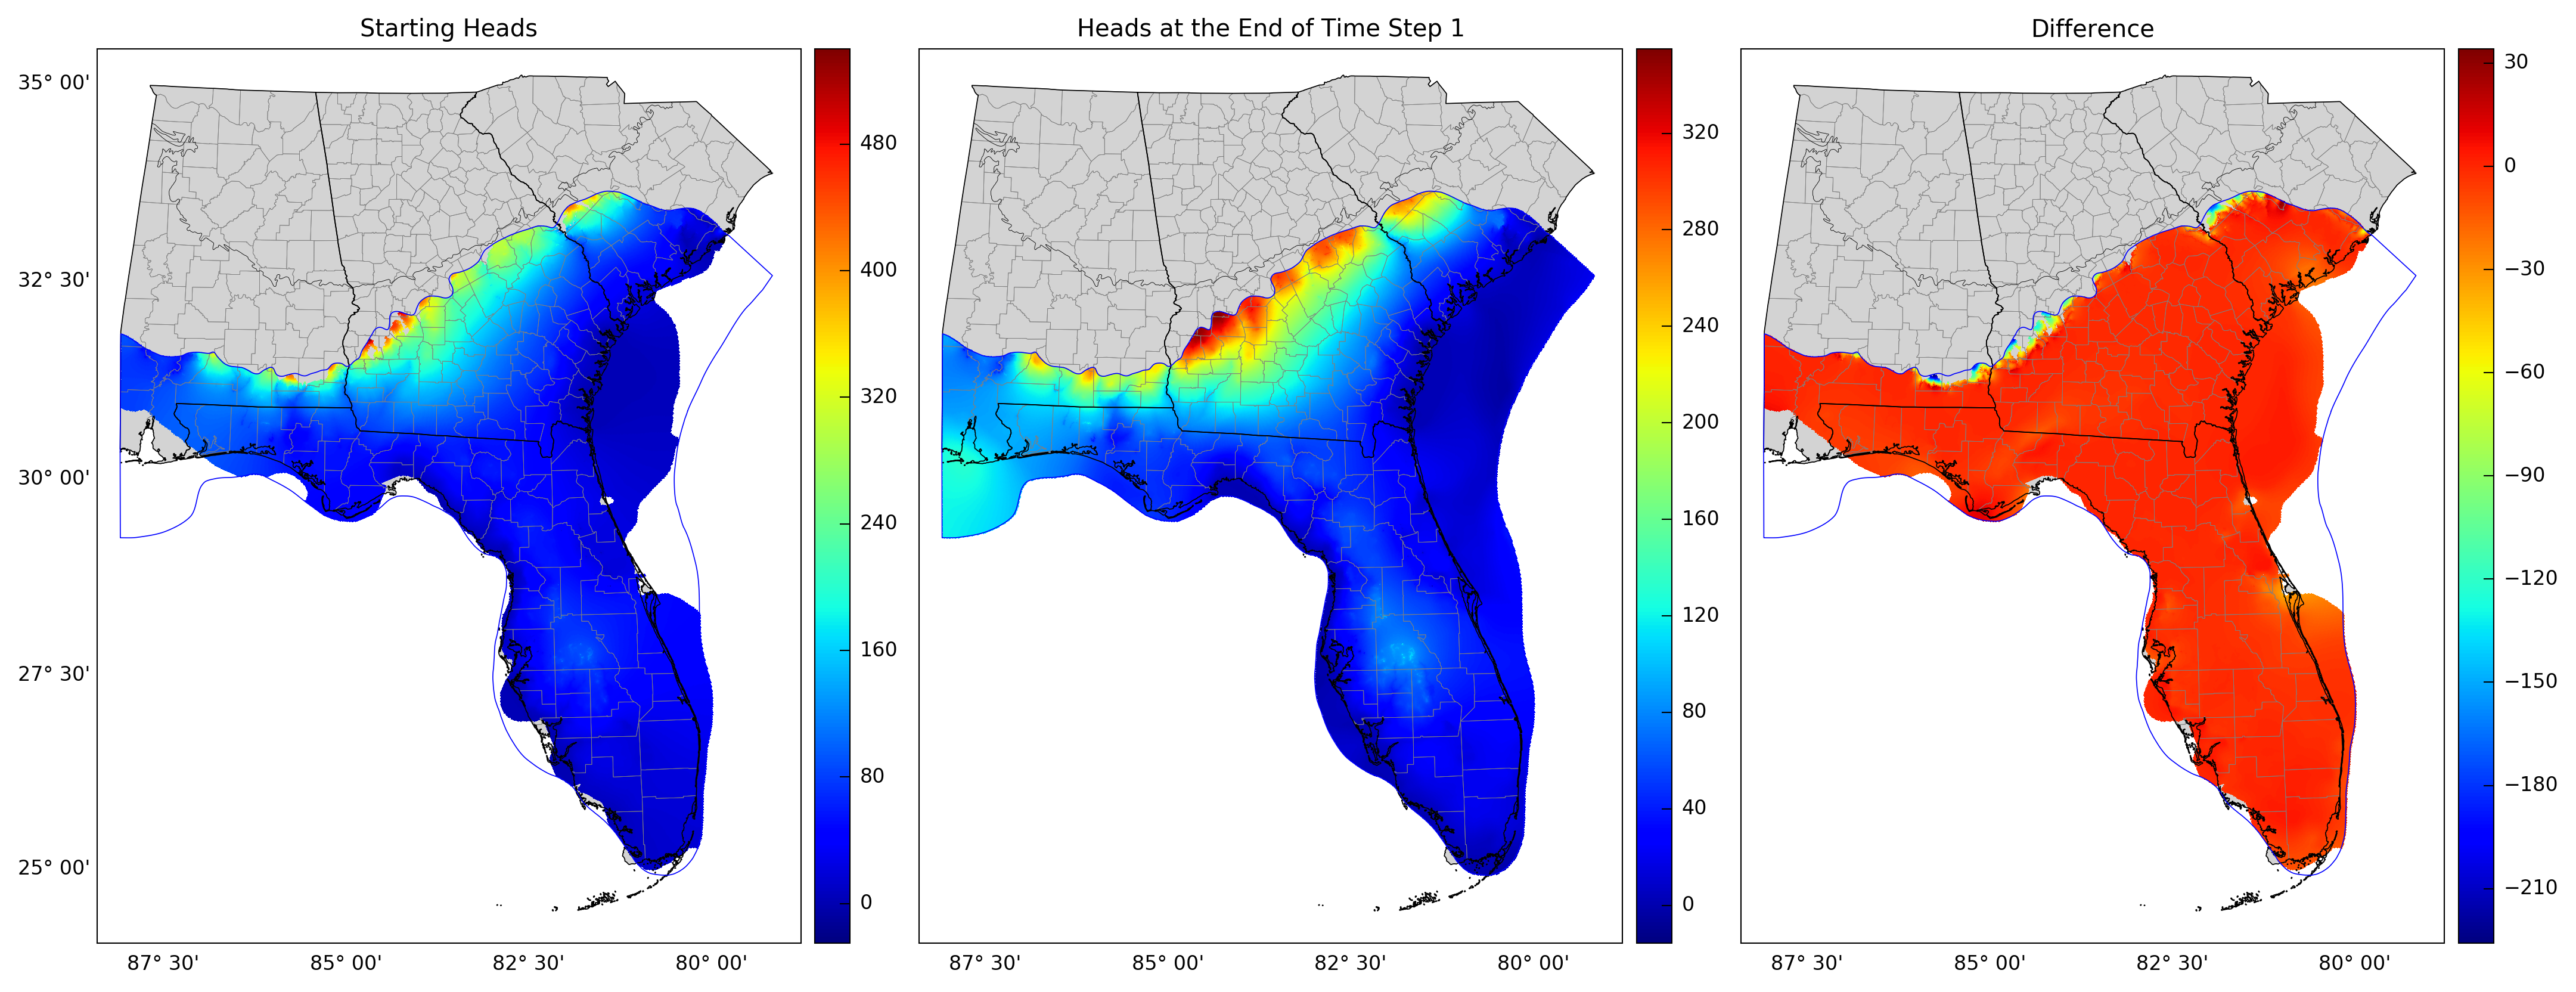

In [3]:
ibnd = ml.bas6.ibound.array
hdobj = HeadFile(os.path.join(modelpath, 'fas.hds'))
start = ml.bas6.strt.array
start = np.ma.masked_where(ibnd==0, start)
start = np.ma.masked_where(start==ml.bas6.hnoflo, start)
per = 0

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 8), sharey=True)

ax1.set_title('Starting Heads')
bmap = ModelBaseMap(proj_x, proj_y, ax=ax1)
quadmesh = bmap.plot_array(start[2, :, :])
cbar = bmap.map.colorbar(quadmesh)

ax2.set_title('Heads at the End of Time Step 1')
head = hdobj.get_data(kstpkper=(0, per))
head = np.ma.masked_where(ibnd==0, head)
bmap = ModelBaseMap(proj_x, proj_y, ax=ax2, draw_parallels=False)
quadmesh = bmap.plot_array(head[2, :, :])
cbar = bmap.map.colorbar(quadmesh)

ax3.set_title('Difference')
bmap = ModelBaseMap(proj_x, proj_y, ax=ax3, draw_parallels=False)
dif = head - start
dif = np.ma.masked_where(ibnd==0, dif)
dif = np.ma.masked_where(dif==0, dif)
quadmesh = bmap.plot_array(dif[2, :, :])
cbar = bmap.map.colorbar(quadmesh)

plt.tight_layout()
plt.show()

###Changes in Zeta Surface
Changes in the zeta surface near Mobile, AL correspond with the higher heads there; however, the changes in peninsular Florida do not correspond with commensurate decreases in head. The overall result is that there is a lot of freshwater at depth where it shouldn't exist near Mobile and saltwater at depth where there should be freshwater along the central Florida highlands and in the thickly confined part of the system in coastal GA.

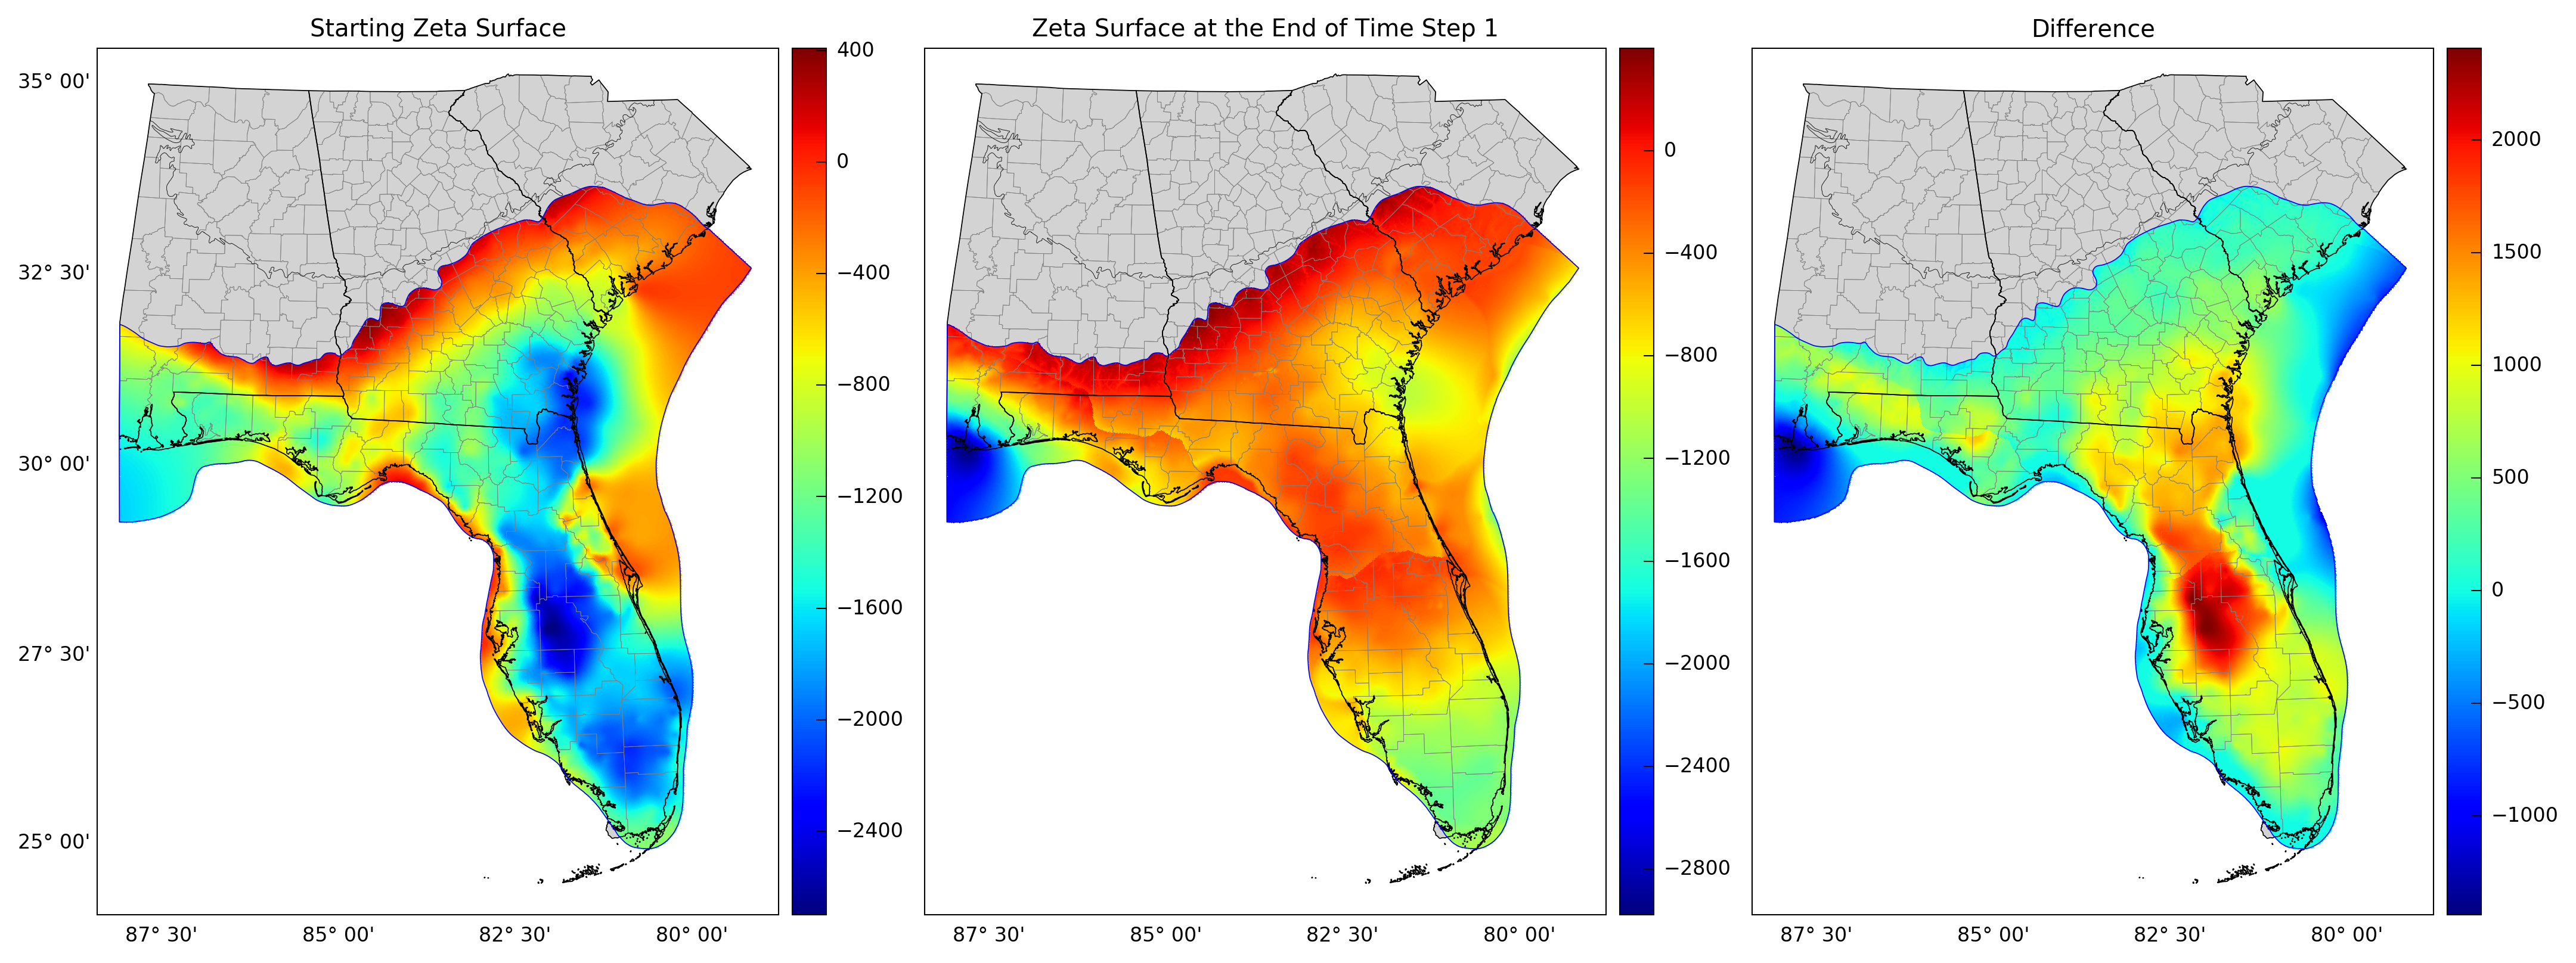

In [4]:
start_zta = np.array([np.loadtxt(os.path.join(modelpath, 'ref', 'top_10ktds.ref'))]*9)
ztaobj = CellBudgetFile(os.path.join(modelpath, 'fas.zta'))
zta = ztaobj.get_data(kstpkper=(0, 0), text='ZETASRF  1')[0]
dif = zta-start_zta

zta = np.ma.masked_where(ibnd==0, zta)
start_zta = np.ma.masked_where(ibnd==0, start_zta)
dif = np.ma.masked_where(ibnd==0, dif)
dif = np.ma.masked_where(dif==0, dif)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 8), sharey=True)

ax1.set_title('Starting Zeta Surface')
bmap = ModelBaseMap(proj_x, proj_y, ax=ax1)
quadmesh = bmap.plot_array(start_zta[2, :, :])
cbar = bmap.map.colorbar(quadmesh)

ax2.set_title('Zeta Surface at the End of Time Step 1')
bmap = ModelBaseMap(proj_x, proj_y, ax=ax2, draw_parallels=False)
quadmesh = bmap.plot_array(zta[2, :, :])
cbar = bmap.map.colorbar(quadmesh)

ax3.set_title('Difference')
bmap = ModelBaseMap(proj_x, proj_y, ax=ax3, draw_parallels=False)
quadmesh = bmap.plot_array(dif[2, :, :])
cbar = bmap.map.colorbar(quadmesh)

plt.tight_layout()
plt.show()

###Relatively Little Change After Timestep 1
Once the initial changes occur during timestep 1, there are no further changes in the zeta surface.

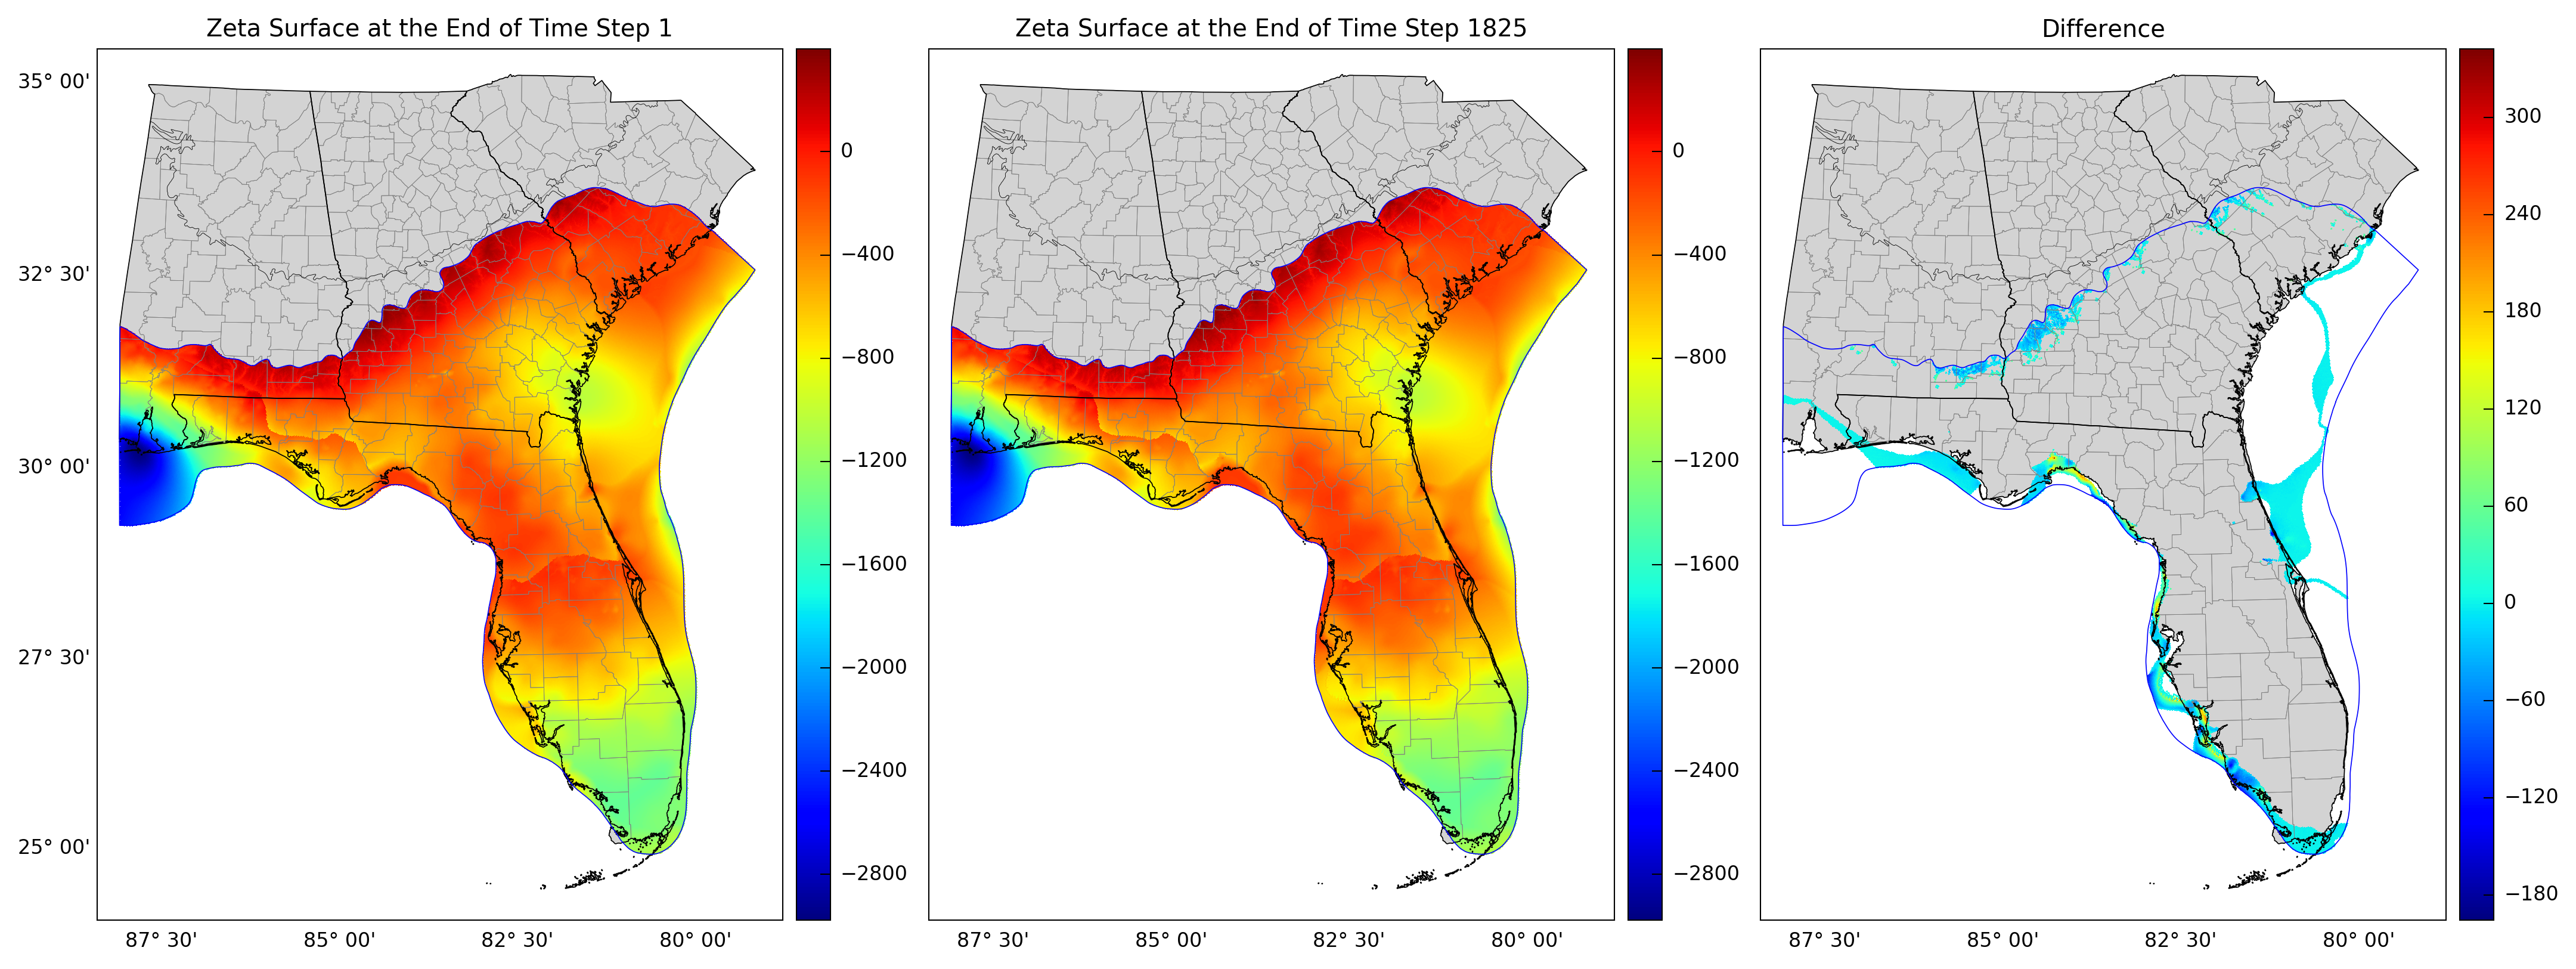

In [5]:
per = 0
ts1 = 0
ts2 = ml.dis.nstp.array[per] - 1
ztaobj = CellBudgetFile(os.path.join(modelpath, 'fas.zta'))
zta1 = ztaobj.get_data(kstpkper=(ts1, per), text='ZETASRF  1')[0]
zta2 = ztaobj.get_data(kstpkper=(ts2, per), text='ZETASRF  1')[0]
dif = zta2 - zta1

zta1 = np.ma.masked_where(ibnd==0, zta1)
zta2 = np.ma.masked_where(ibnd==0, zta2)
dif = np.ma.masked_where(ibnd==0, dif)
dif = np.ma.masked_where(dif==0, dif)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 8), sharey=True)

ax1.set_title('Zeta Surface at the End of Time Step 1')
bmap = ModelBaseMap(proj_x, proj_y, ax=ax1)
quadmesh = bmap.plot_array(zta1[2, :, :])
cbar = bmap.map.colorbar(quadmesh)

ax2.set_title('Zeta Surface at the End of Time Step {}'.format(ts2+1))
bmap = ModelBaseMap(proj_x, proj_y, ax=ax2, draw_parallels=False)
quadmesh = bmap.plot_array(zta2[2, :, :])
cbar = bmap.map.colorbar(quadmesh)

ax3.set_title('Difference')
bmap = ModelBaseMap(proj_x, proj_y, ax=ax3, draw_parallels=False)
quadmesh = bmap.plot_array(dif[2, :, :])
cbar = bmap.map.colorbar(quadmesh)

plt.tight_layout()
plt.show()

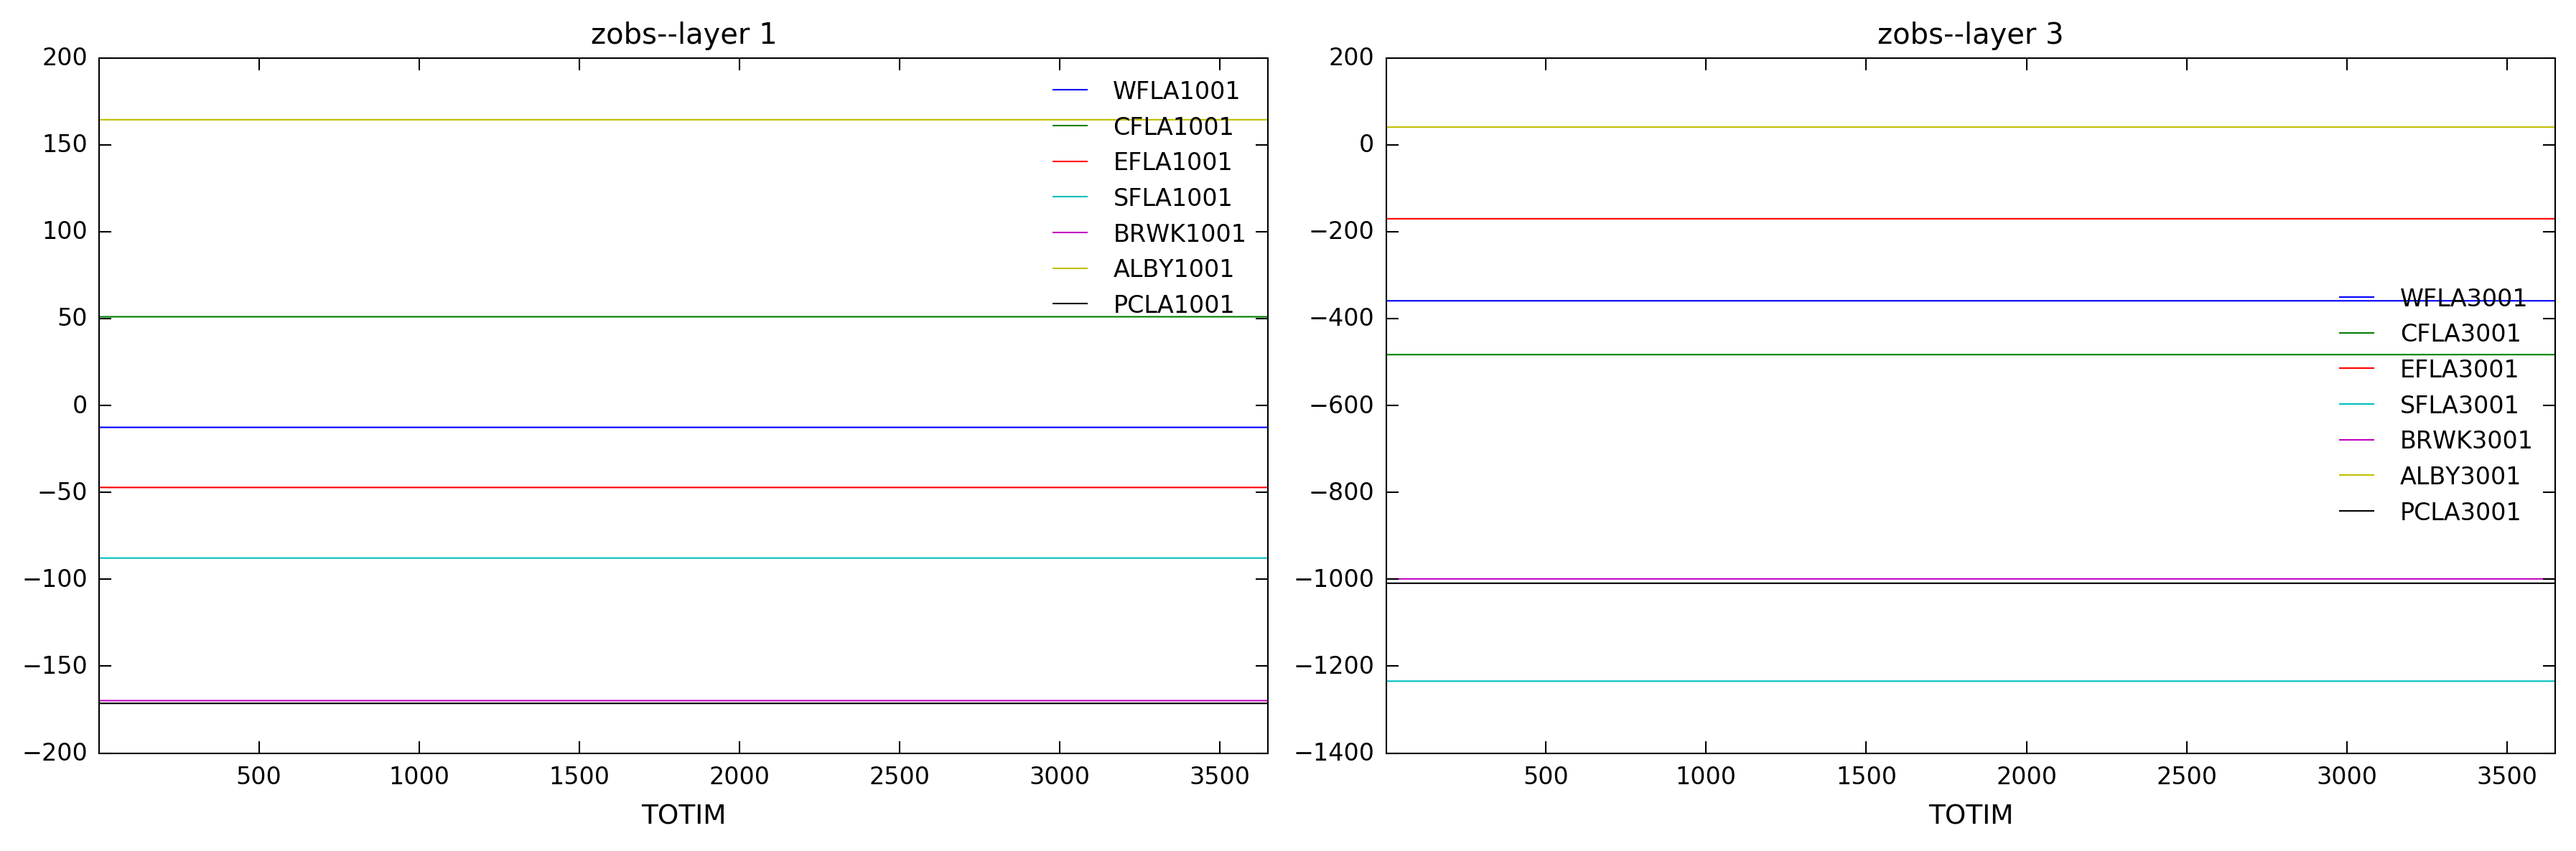

In [6]:
zobs = np.genfromtxt(os.path.join(modelpath, 'fas.zobs'), names=True)
zobs = pd.DataFrame.from_records(zobs, columns=zobs.dtype.names, index='TOTIM')

zobs_l1 = zobs[[col for col in zobs.columns.tolist() if '1001' in col]]
zobs_l3 = zobs[[col for col in zobs.columns.tolist() if '3001' in col]]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
chart1 = zobs_l1.plot(kind='line', title='zobs--layer 1', ax=ax1)
chart2 = zobs_l3.plot(kind='line', title='zobs--layer 3', ax=ax2)

plt.tight_layout()
plt.show()